In [1]:
import random

# scp -i ~/Desktop/www/wolanx-note/__cicd__/ssh-106006/KEY-GIMC-BIGDATA-D.pem vb.ipynb root@10.231.9.124:/www/test/vb-test/
import h5py
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from h5py import File
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim
from torch import utils
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchmetrics import F1Score, Accuracy
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [2]:
# f: File = h5py.File("/www/test/vb-test/data/fault-data/fault_data.h5", "r")
f: File = h5py.File("./data/fault-data-2280.h5", "r")

codeArr = f['label']
waveArr = f['wave_data']
fftAbsArr = f['wave_fft_abs']
dataSize = len(codeArr)

# codeArr[:] > 4

waveWeb = waveArr[1]
waveWeb = np.array(waveWeb)

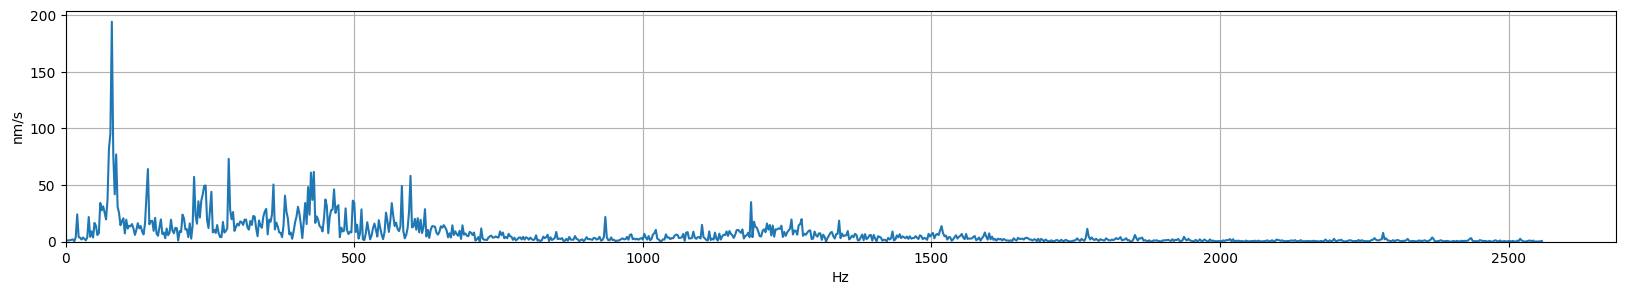

In [3]:
cnt = len(waveWeb)

fftArr = np.fft.fft(waveWeb)
hzArr = np.fft.fftfreq(len(fftArr), 1 / 5120)

hzArr = hzArr[:cnt // 2]
fftArr = fftArr[:cnt // 2]

# 绘制频域数据
plt.figure(figsize=(20, 3))
# plt.plot(waveWeb)
plt.plot(hzArr, np.abs(fftArr))
plt.xlim(0)
plt.ylim(0)
plt.xlabel('Hz')
plt.ylabel('nm/s')
plt.grid()
plt.show()

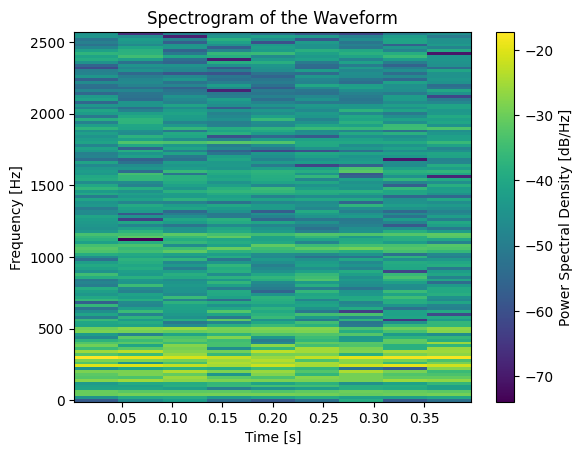

In [4]:
# 频谱图
hzArr, times, Sxx = signal.spectrogram(waveArr[219], 5120)

plt.pcolormesh(times, hzArr, 10 * np.log10(Sxx))
plt.title('Spectrogram of the Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power Spectral Density [dB/Hz]')
plt.show()

In [5]:
# 画图 tool
def drawWave(ids: list = [], df=None, log=False):
    fig, ax = plt.subplots(nrows=len(ids), ncols=2, figsize=(20, 10), dpi=100)
    for i, idx in enumerate(ids):
        y, y_, ok = df.loc[i]['y'], df.loc[i]['y_'], df.loc[i]['ok']
        # ax[i, 0].set_ylim(-2.5, 2.5)
        ax[i, 0].set_ylabel(f"{idx}    ", rotation=0, fontdict={'size': 16})
        ax[i, 0].plot(waveArr[idx])

        color_ = '#0f0' if ok else '#f00'
        ax[i, 1].set_title(f"{y} - {y_}", fontdict={'size': 16, 'color': color_}, x=0.5, y=0.5)
        # ax[i, 1].set_ylim(0, max(fftAbsArr[idx]))
        if log:
            ax[i, 1].set_yscale("symlog")
        ax[i, 1].plot(fftAbsArr[idx])


def drawHis(ids: list = [], df=None, log=False):
    nrows, ncols = len(ids) // 5, 5
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), dpi=100)
    for i, id_ in enumerate(ids):
        y, y_, ok = df.loc[i]['y'], df.loc[i]['y_'], df.loc[i]['ok']
        hzArr, times, Sxx = signal.spectrogram(np.array(waveArr[id_], dtype=np.float32), 5120)
        ax[i // 5, i % 5].set_ylabel(f"{id_}", rotation=0, fontdict={'size': 16}, x=1, y=0.5)
        color_ = '#0f0' if ok else '#f00'
        ax[i // 5, i % 5].set_title(f"{y} - {y_}", fontdict={'size': 24, 'color': color_}, x=0.5, y=0.5)
        ax[i // 5, i % 5].pcolormesh(times, hzArr, 10 * np.log10(Sxx))

In [6]:
class MyDataModule(pl.LightningDataModule):
    def __init__(self, trainSet, batchSize: int, transform=None):
        super().__init__()
        self.batchSize = batchSize
        self.transform = transform
        self.trainSet, self.validSet, self.testsSet = utils.data.random_split(trainSet, [0.7, 0.2, 0.1])
        print('dataset num', len(self.trainSet), len(self.validSet), len(self.testsSet))

    def train_dataloader(self):
        return DataLoader(self.trainSet, batch_size=self.batchSize, shuffle=False)

    def val_dataloader(self):
        return DataLoader(self.validSet, batch_size=self.batchSize, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.testsSet, batch_size=self.batchSize, shuffle=False)

    def apply_transform(self, x):
        if self.transform:
            x = self.transform(x)
        return x


def min_max_scale(x):
    min_val = torch.min(x)
    max_val = torch.max(x)
    scaled_data = (x - min_val) / (max_val - min_val)
    return scaled_data


# 定义 torchvision.transforms 的组合
custom_transform = transforms.Compose([
    transforms.Lambda(lambda x: min_max_scale(x)),
])
scaler = MinMaxScaler(feature_range=(0, 1))
fftAbsArr2 = scaler.fit_transform(fftAbsArr)

dataset = TensorDataset(torch.tensor(fftAbsArr), torch.tensor(codeArr, dtype=torch.int64))
dm = MyDataModule(dataset, batchSize=128, transform=None)  # custom_transform

dataset num 1597 456 228


C:\Users\106006\AppData\Local\Temp\ipykernel_20660\2298923058.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  dataset = TensorDataset(torch.tensor(fftAbsArr), torch.tensor(codeArr, dtype=torch.int64))


In [7]:
class MyModel(pl.LightningModule):
    def __init__(self, lr: float):
        super().__init__()
        self.save_hyperparameters("lr")

        self.val_acc = Accuracy(task="multiclass", num_classes=6)
        self.val_f1 = F1Score(task="multiclass", num_classes=6)

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(p=.25)
        self.fc1 = nn.Linear(4096, 256)
        self.fc2 = nn.Linear(256, 6)

    def forward(self, x):
        x = x.view(-1, 1, 1024)  # [64, 1, 1024]
        x = self.conv1(x)  # [64, 3, 1024]
        x = self.relu(x)
        x = self.pool(x)  # [64, 3, 512]
        x = self.conv2(x)  # [64, 3, 512]
        x = self.relu(x)
        x = self.pool(x)  # [64, 3, 256]
        x = torch.flatten(x, 1)  # [64, 768]

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)  # batch, 6

        # x = F.sigmoid(x)  # batch, 6
        # x = F.sigmoid(x, dim=-1)  # batch, 6
        return x

    def configure_optimizers(self):
        hparams = self.hparams
        optimizer = optim.Adam(self.parameters(), lr=hparams.lr, weight_decay=0.001)
        return optimizer

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = F.cross_entropy(outputs, labels) # , reduction='sum'
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)

        loss = F.cross_entropy(outputs, labels)
        _, y_ = torch.max(outputs, 1)
        # print('yt.shape', labels.shape, labels)
        # print('y_.shape', y_.shape, y_)
        self.val_acc.update(y_, labels)
        self.val_f1.update(y_, labels)

        self.log("val_loss", loss)
        return loss

    def on_validation_epoch_end(self) -> None:
        print("{} val acc={:.3f} f1={:.3f}".format(self.current_epoch, self.val_acc.compute(), self.val_f1.compute()))
        self.val_acc.reset()
        self.val_f1.reset()

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)

        loss = F.cross_entropy(outputs, labels)
        _, y_ = torch.max(outputs, 1)
        print('yt.shape', labels.shape, labels)
        print('y_.shape', y_.shape, y_)
        self.val_acc.update(y_, labels)
        self.val_f1.update(y_, labels)

        self.log("test_loss", loss)

    def on_test_epoch_end(self) -> None:
        print("{} test acc={:.3f} f1={:.3f}".format(self.current_epoch, self.val_acc.compute(), self.val_f1.compute()))
        self.val_acc.reset()
        self.val_f1.reset()


model = MyModel(lr=0.001)

logger = None
trainer = pl.Trainer(logger=logger, max_epochs=50, enable_progress_bar=True, enable_checkpointing=False)
trainer.fit(model, datamodule=dm)
trainer.test(model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Programs\python\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name     | Type               | Params
------------------------------------------------
0 | val_acc  | MulticlassAccuracy | 0     
1 | val_f1   | MulticlassF1Score  | 0     
2 | conv1    | Conv1d             | 32    
3 | conv2    | Conv1d             | 400   
4 | relu     | ReLU               | 0     
5 | pool     | MaxPool1d

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Programs\python\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


0 val acc=0.188 f1=0.188


C:\Programs\python\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Programs\python\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

0 val acc=0.583 f1=0.583


Validation: |          | 0/? [00:00<?, ?it/s]

1 val acc=0.827 f1=0.827


Validation: |          | 0/? [00:00<?, ?it/s]

2 val acc=0.829 f1=0.829


Validation: |          | 0/? [00:00<?, ?it/s]

3 val acc=0.868 f1=0.868


Validation: |          | 0/? [00:00<?, ?it/s]

4 val acc=0.893 f1=0.893


Validation: |          | 0/? [00:00<?, ?it/s]

5 val acc=0.904 f1=0.904


Validation: |          | 0/? [00:00<?, ?it/s]

6 val acc=0.912 f1=0.912


Validation: |          | 0/? [00:00<?, ?it/s]

7 val acc=0.923 f1=0.923


Validation: |          | 0/? [00:00<?, ?it/s]

8 val acc=0.923 f1=0.923


Validation: |          | 0/? [00:00<?, ?it/s]

9 val acc=0.921 f1=0.921


Validation: |          | 0/? [00:00<?, ?it/s]

10 val acc=0.914 f1=0.914


Validation: |          | 0/? [00:00<?, ?it/s]

11 val acc=0.945 f1=0.945


Validation: |          | 0/? [00:00<?, ?it/s]

12 val acc=0.925 f1=0.925


Validation: |          | 0/? [00:00<?, ?it/s]

13 val acc=0.923 f1=0.923


Validation: |          | 0/? [00:00<?, ?it/s]

14 val acc=0.936 f1=0.936


Validation: |          | 0/? [00:00<?, ?it/s]

15 val acc=0.921 f1=0.921


Validation: |          | 0/? [00:00<?, ?it/s]

16 val acc=0.930 f1=0.930


Validation: |          | 0/? [00:00<?, ?it/s]

17 val acc=0.928 f1=0.928


Validation: |          | 0/? [00:00<?, ?it/s]

18 val acc=0.932 f1=0.932


Validation: |          | 0/? [00:00<?, ?it/s]

19 val acc=0.917 f1=0.917


Validation: |          | 0/? [00:00<?, ?it/s]

20 val acc=0.919 f1=0.919


Validation: |          | 0/? [00:00<?, ?it/s]

21 val acc=0.919 f1=0.919


Validation: |          | 0/? [00:00<?, ?it/s]

22 val acc=0.928 f1=0.928


Validation: |          | 0/? [00:00<?, ?it/s]

23 val acc=0.919 f1=0.919


Validation: |          | 0/? [00:00<?, ?it/s]

24 val acc=0.921 f1=0.921


Validation: |          | 0/? [00:00<?, ?it/s]

25 val acc=0.925 f1=0.925


Validation: |          | 0/? [00:00<?, ?it/s]

26 val acc=0.932 f1=0.932


Validation: |          | 0/? [00:00<?, ?it/s]

27 val acc=0.923 f1=0.923


Validation: |          | 0/? [00:00<?, ?it/s]

28 val acc=0.923 f1=0.923


Validation: |          | 0/? [00:00<?, ?it/s]

29 val acc=0.925 f1=0.925


Validation: |          | 0/? [00:00<?, ?it/s]

30 val acc=0.932 f1=0.932


Validation: |          | 0/? [00:00<?, ?it/s]

31 val acc=0.914 f1=0.914


Validation: |          | 0/? [00:00<?, ?it/s]

32 val acc=0.919 f1=0.919


Validation: |          | 0/? [00:00<?, ?it/s]

33 val acc=0.923 f1=0.923


Validation: |          | 0/? [00:00<?, ?it/s]

34 val acc=0.925 f1=0.925


Validation: |          | 0/? [00:00<?, ?it/s]

35 val acc=0.923 f1=0.923


Validation: |          | 0/? [00:00<?, ?it/s]

36 val acc=0.914 f1=0.914


Validation: |          | 0/? [00:00<?, ?it/s]

37 val acc=0.930 f1=0.930


Validation: |          | 0/? [00:00<?, ?it/s]

38 val acc=0.921 f1=0.921


Validation: |          | 0/? [00:00<?, ?it/s]

39 val acc=0.923 f1=0.923


Validation: |          | 0/? [00:00<?, ?it/s]

40 val acc=0.928 f1=0.928


Validation: |          | 0/? [00:00<?, ?it/s]

41 val acc=0.923 f1=0.923


Validation: |          | 0/? [00:00<?, ?it/s]

42 val acc=0.917 f1=0.917


Validation: |          | 0/? [00:00<?, ?it/s]

43 val acc=0.923 f1=0.923


Validation: |          | 0/? [00:00<?, ?it/s]

44 val acc=0.925 f1=0.925


Validation: |          | 0/? [00:00<?, ?it/s]

45 val acc=0.921 f1=0.921


Validation: |          | 0/? [00:00<?, ?it/s]

46 val acc=0.923 f1=0.923


Validation: |          | 0/? [00:00<?, ?it/s]

47 val acc=0.921 f1=0.921


Validation: |          | 0/? [00:00<?, ?it/s]

48 val acc=0.919 f1=0.919


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


49 val acc=0.914 f1=0.914


C:\Programs\python\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

yt.shape torch.Size([128]) tensor([4, 4, 0, 4, 4, 4, 4, 0, 1, 0, 0, 2, 0, 4, 3, 3, 0, 0, 4, 4, 0, 0, 1, 0,
        4, 0, 4, 2, 0, 1, 0, 0, 0, 0, 0, 4, 1, 1, 1, 4, 2, 4, 0, 2, 0, 1, 0, 2,
        3, 1, 0, 0, 4, 4, 4, 4, 3, 0, 0, 4, 0, 0, 2, 4, 0, 0, 0, 0, 4, 1, 0, 3,
        2, 0, 0, 0, 1, 1, 3, 0, 2, 3, 0, 4, 2, 0, 1, 4, 2, 0, 4, 4, 0, 0, 1, 1,
        0, 0, 2, 1, 0, 4, 4, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 4, 4, 0, 0, 4, 3, 0,
        2, 0, 0, 0, 1, 2, 3, 0])
y_.shape torch.Size([128]) tensor([4, 4, 0, 4, 4, 4, 4, 0, 1, 0, 0, 2, 0, 4, 3, 0, 0, 0, 4, 4, 0, 3, 1, 0,
        4, 0, 4, 2, 0, 1, 0, 0, 0, 0, 0, 4, 1, 1, 1, 4, 2, 4, 0, 2, 0, 1, 0, 2,
        3, 1, 0, 0, 4, 4, 4, 4, 3, 3, 0, 4, 0, 0, 2, 4, 0, 0, 0, 3, 4, 1, 3, 3,
        2, 0, 0, 0, 1, 1, 0, 0, 2, 3, 0, 4, 2, 0, 1, 4, 2, 3, 4, 4, 0, 0, 1, 1,
        0, 0, 2, 4, 0, 4, 4, 0, 1, 0, 3, 1, 0, 3, 0, 1, 0, 4, 4, 0, 0, 4, 0, 0,
        2, 0, 0, 0, 1, 2, 0, 0])
yt.shape torch.Size([100]) tensor([4, 0, 4, 0, 2, 4, 4, 4, 1, 1, 0, 1, 0, 4, 0, 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.27298784255981445    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.27298784255981445}]

      id  y  y_     ratio     ok
0   1756  3   3  0.983745   True
1    107  3   3  0.987215   True
2   1955  0   0  0.999925   True
3   1436  2   2  1.000000   True
4   1016  1   1  0.590032   True
5    350  0   0  0.999285   True
6    342  0   0  0.996521   True
7   1873  0   0  0.974823   True
8   1823  3   0  0.503969  False
9   1066  1   1  1.000000   True
10   953  0   0  0.999889   True
11  1385  4   4  0.999814   True
12   161  3   3  0.993881   True
13   378  0   0  0.980984   True
14   958  0   0  0.999754   True
15  1395  4   4  0.986280   True
16  1999  0   0  0.999633   True
17  1106  1   1  1.000000   True
18   289  0   0  0.999720   True
19  1407  4   4  0.999996   True


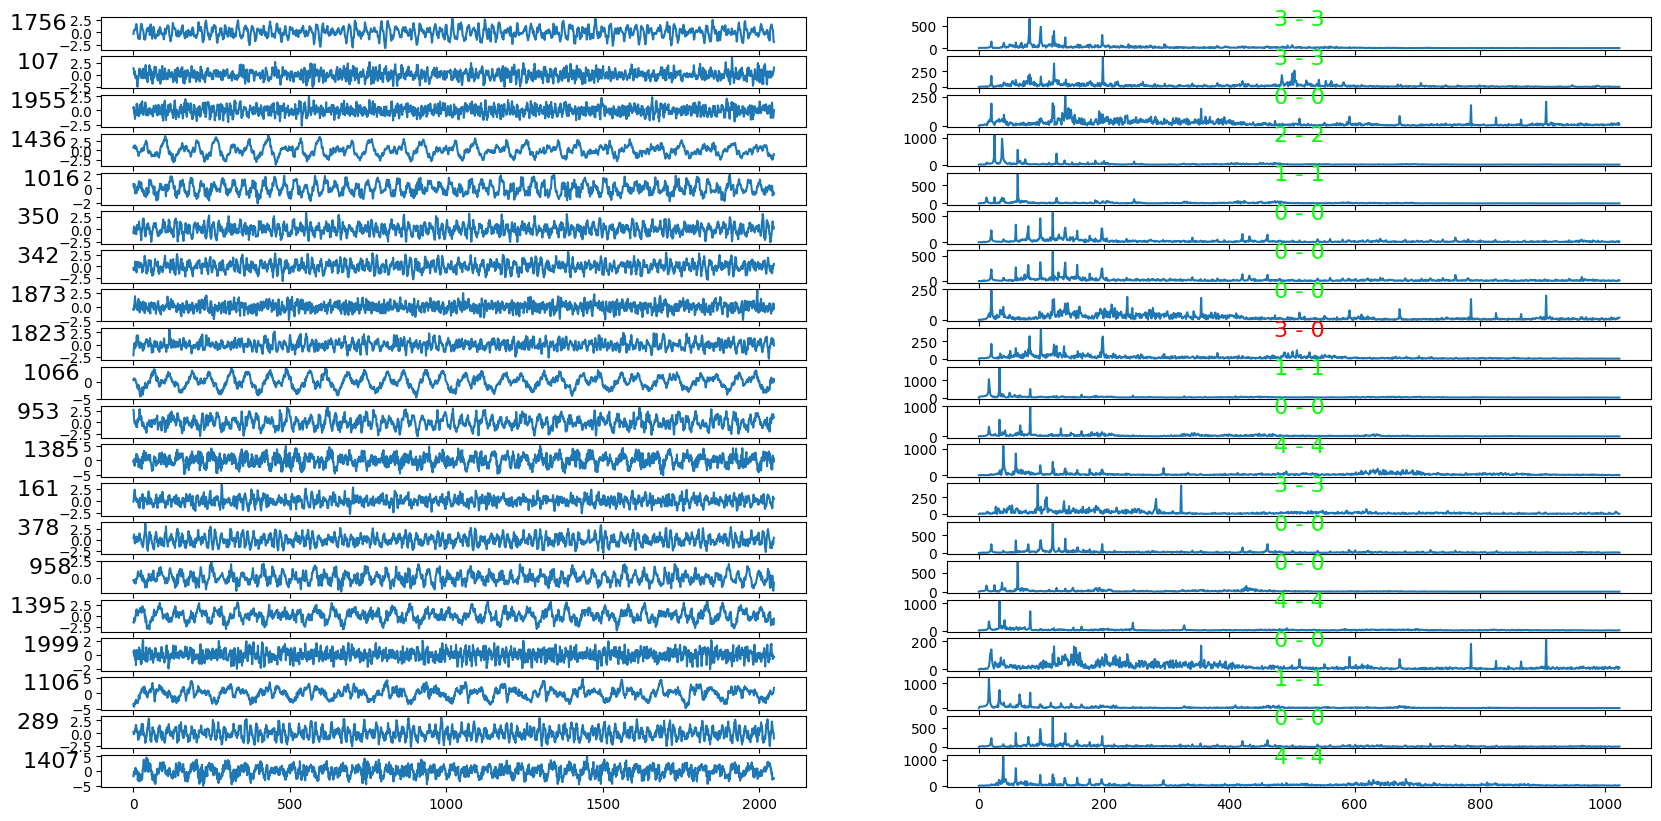

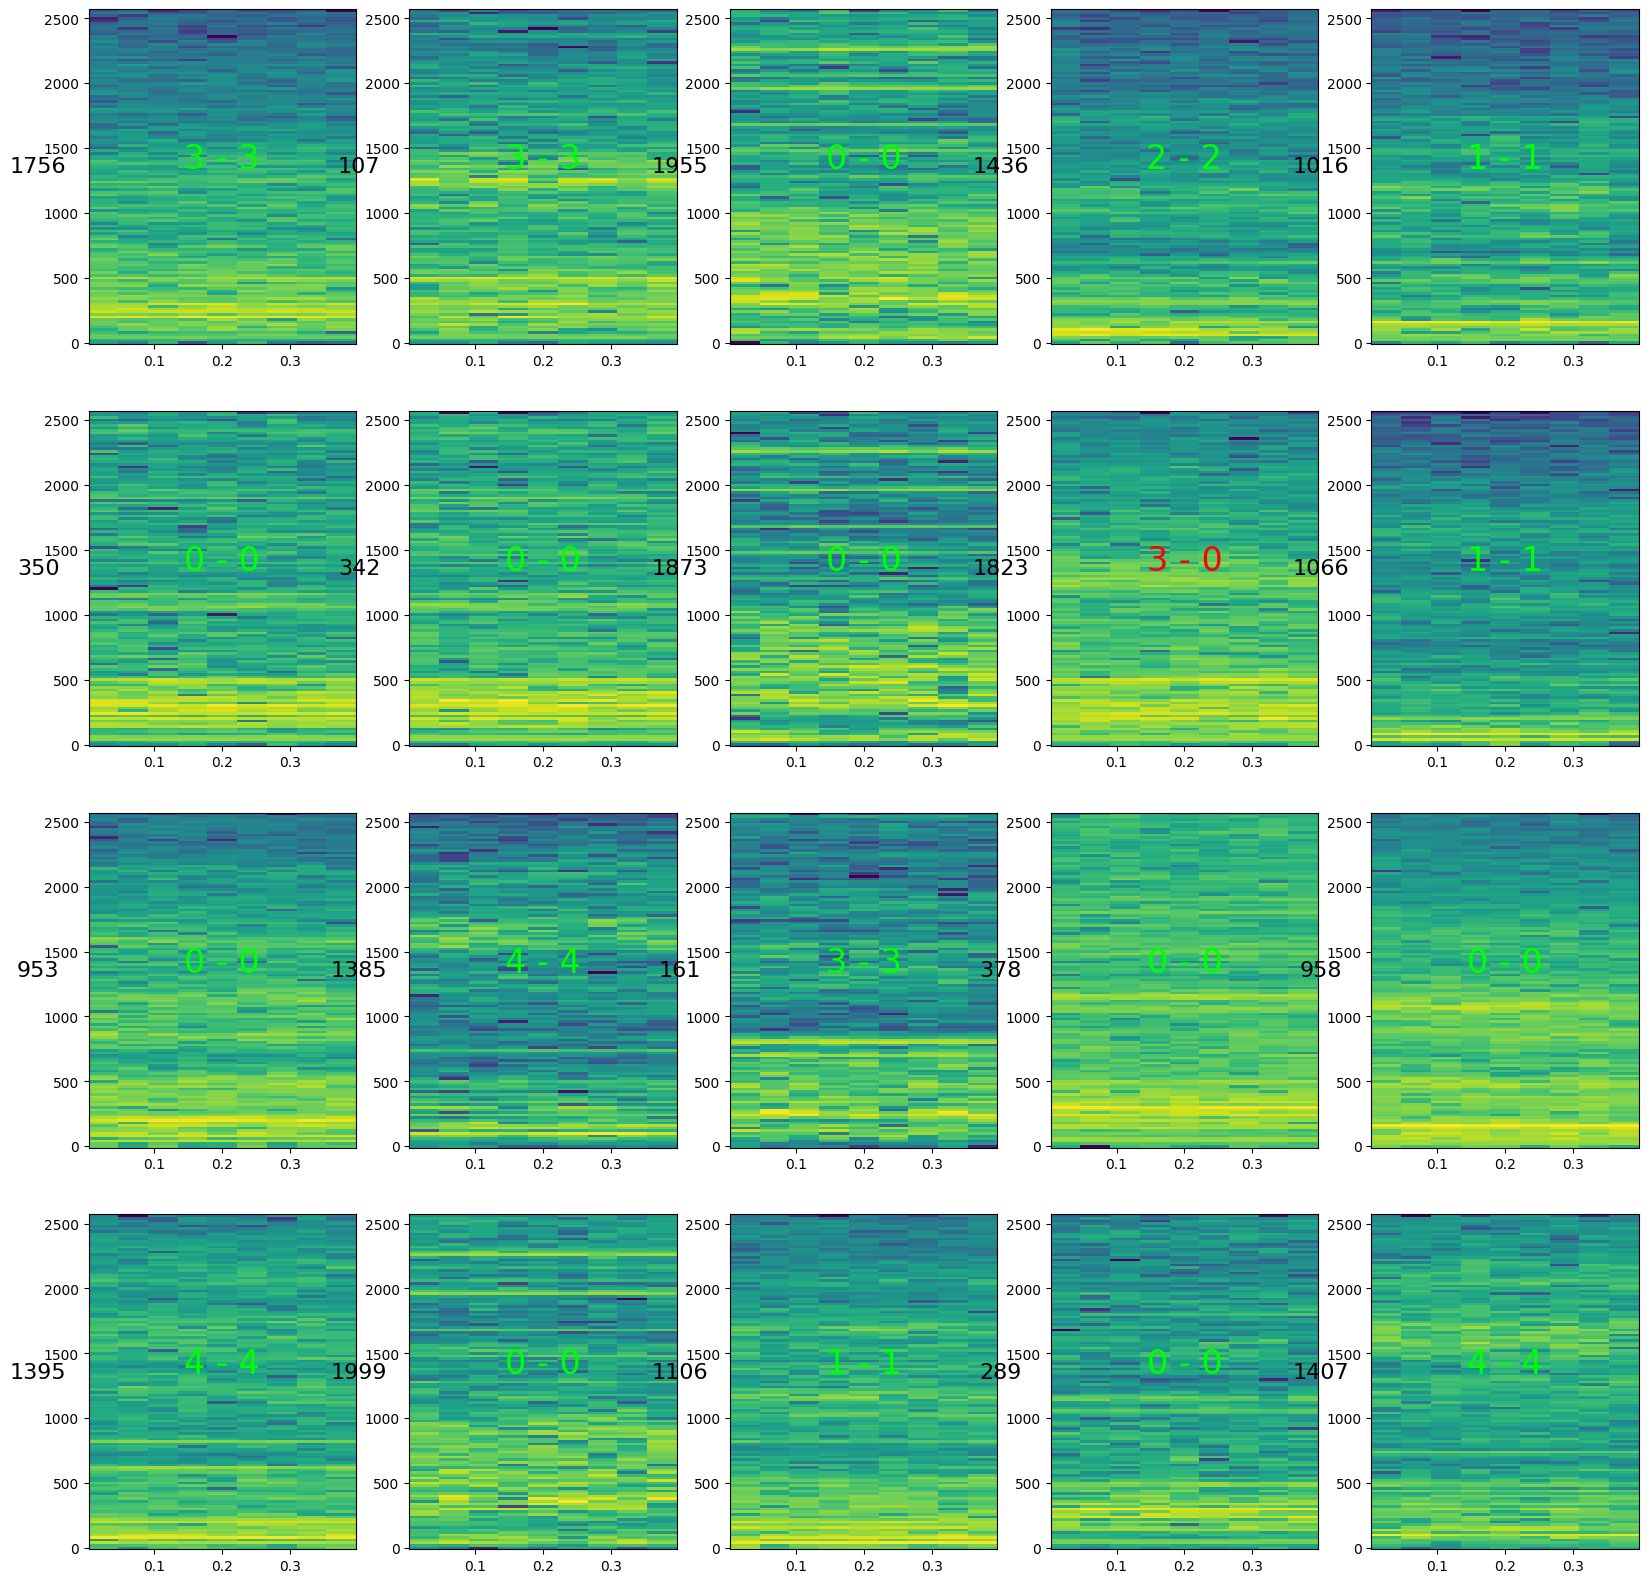

In [12]:
"""
BaseplateUnbalance: 1
Misaligned: 2
Bearing: 3
ImpellerUnbalance: 4
Cavitation: 5
"""
model.eval()

_page = 0
# ids = range(10 * _page, 10 * _page + 25, 1)
ids = [random.randint(1, 2000) for i in range(20)]

df = pd.DataFrame(columns=['id', "y", "y_", 'ratio'])
for i, id_ in enumerate(ids):
    x = torch.tensor([[fftAbsArr[id_]]], dtype=torch.float32)
    ret = model(x)
    # print(ret[0])

    y = codeArr[id_]
    # p_, y_ = torch.max(ret[0], -1)
    p_, y_ = torch.max(torch.softmax(ret[0], dim=-1), dim=-1)
    df.loc[len(df)] = {'id': id_, 'y': y, "y_": y_.item(), 'ratio': p_.item()}

df["ok"] = df["y"] == df["y_"]
print(df)

drawWave(ids=ids, df=df, log=False)
drawHis(ids=ids, df=df, log=True)

In [9]:
from sklearn.metrics import accuracy_score, f1_score
import onnxruntime as ort

sess = ort.InferenceSession("vb-2023-11-22.onnx")


def get_score(dataSet, label: str = ''):
    y_pred = []
    for one in dataSet:
        # print(dm.apply_transform(one[0]))
        y_pred.append(torch.argmax(model(one[0].unsqueeze(0)), dim=1).item())

    acc = accuracy_score(dataSet[:][1], y_pred)
    f1 = f1_score(dataSet[:][1], y_pred, average='macro')
    print('acc {:.3f} , f1 {:.3f} {}'.format(acc, f1, label))


def get_onnx(dataSet, label: str = ''):
    y_pred = []
    for one in dataSet:
        result = sess.run(None, {"input": np.array(one[0], np.float32)})[0]
        y_pred.append(np.argmax(result))

    arr = dataSet[:][1].numpy().tolist()
    # print(arr)
    # print(y_pred)
    acc = accuracy_score(arr, y_pred)
    f1 = f1_score(arr, y_pred, average='macro')
    print('acc {:.3f} , f1 {:.3f} {}'.format(acc, f1, label))


get_score(dm.trainSet, 'train')
get_score(dm.validSet, 'valid')
get_score(dm.testsSet, 'tests')
print('------ model')
get_score(dataset)

print()
print()

# print(dataset[:10])

get_onnx(dm.trainSet, 'train')
get_onnx(dm.validSet, 'valid')
get_onnx(dm.testsSet, 'tests')
print('------ onnx')
get_onnx(dataset)
# dm.trainSet[1][0].numpy()

acc 0.989 , f1 0.987 train
acc 0.914 , f1 0.832 valid
acc 0.904 , f1 0.852 tests
------ model
acc 0.966 , f1 0.945 


acc 0.725 , f1 0.621 train
acc 0.746 , f1 0.656 valid
acc 0.684 , f1 0.566 tests
------ onnx
acc 0.725 , f1 0.622 


In [10]:
inputs = torch.randn(1024).unsqueeze(0)  # sample
print(inputs.shape)

model.to_onnx(
    'vb-2024-05-14.onnx',
    input_sample=inputs,
    export_params=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
)

torch.Size([1, 1024])
